In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Softmax, LSTM, Conv2D, Flatten, MaxPooling2D, LayerNormalization, Dropout
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
# ---------------------------------------------
# MoE Text Generation Model Components
# ---------------------------------------------

class Expert(Model):
    def __init__(self, d_model):
        super().__init__()
        self.norm = LayerNormalization()
        self.dense1 = Dense(64, activation='relu')
        self.dropout = Dropout(0.2)
        self.dense2 = Dense(d_model)
    def call(self, x):
        x = self.norm(x)
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

class GatingNetwork(Model):
    def __init__(self, d_model, num_experts):
        super().__init__()
        self.dense = Dense(num_experts)
        self.softmax = Softmax(axis=-1)
    def call(self, x):
        logits = self.dense(x)
        return self.softmax(logits)

class MoEResponseGenerator(Model):
    def __init__(self, vocab_size, d_model, num_experts, max_resp_len, lstm_units=128):
        super().__init__()
        self.embedding = Embedding(vocab_size, d_model, mask_zero=True)
        self.global_pool = GlobalAveragePooling1D()
        self.num_experts = num_experts
        self.experts = [Expert(d_model) for _ in range(num_experts)]
        self.gating_net = GatingNetwork(d_model, num_experts)
        self.lstm_units = lstm_units
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.to_h = Dense(lstm_units)
        self.to_c = Dense(lstm_units)
        self.output_layer = Dense(vocab_size)
        self.max_resp_len = max_resp_len

    def call(self, inputs, training=False):
        input_seq, resp_in_seq = inputs
        enc_emb = self.embedding(input_seq)
        pooled = self.global_pool(enc_emb)

        gating_probs = self.gating_net(pooled)
        expert_outs = tf.stack([expert(pooled) for expert in self.experts], axis=1)
        gated_rep = tf.reduce_sum(tf.expand_dims(gating_probs, 2) * expert_outs, axis=1)

        h_state = self.to_h(gated_rep)
        c_state = self.to_c(gated_rep)

        resp_emb = self.embedding(resp_in_seq)
        lstm_out, _, _ = self.lstm(resp_emb, initial_state=[h_state, c_state])

        logits = self.output_layer(lstm_out)
        return logits, gating_probs

In [3]:
# ---------------------------------------------
# Utility functions for text encoding and generation
# ---------------------------------------------

# (Your train_data list is assumed defined here - omitted for brevity, but same as your list)

# Build vocabulary based on train_data (input + responses)
train_data = [
    ("hello there", "hi, how can I help"),
    ("hi", "hello, what can I do"),
    ("goodbye", "goodbye, have a nice day"),
    ("see you later", "see you soon, goodbye"),
    ("I want to order pizza", "sure, what toppings do you want"),
    ("can I get a burger", "what size burger would you like"),
    ("what is the weather", "the weather today is sunny"),
    ("is it raining", "no rain expected today"),
    ("hey, I want some pasta", "what kind of pasta would you prefer"),
    ("do you have vegetarian options?", "yes, we have several vegetarian dishes"),
    ("good morning", "good morning, how may I assist you?"),
    ("bye", "take care, see you later"),
    ("will it be hot today?", "expect warm temperatures all day"),
    ("can I order a salad?", "what dressing would you like on your salad?"),
    ("thanks, goodbye", "you're welcome, goodbye!"),
    ("tell me the forecast", "the forecast shows clear skies"),
    ("what's your name?", "i am your assistant, here to help"),
    ("can I have a coffee?", "sure, would you like it black or with milk?"),
    ("thank you for the help", "happy to assist you anytime"),
    ("are you open today?", "yes, we are open from 9 am to 9 pm"),
    ("could you help me with my order", "of course, what would you like to order"),
    ("are there any gluten free options", "yes, we have several gluten free dishes available"),
    ("what are today's specials", "today's special is grilled salmon with vegetables"),
    ("how late are you open", "we are open until 10 pm tonight"),
    ("can you recommend a dessert", "our chocolate lava cake is very popular"),
    ("I need to change my order", "sure, what changes would you like to make"),
    ("do you deliver", "yes, we deliver within a 5 mile radius"),
    ("what payment methods do you accept", "we accept cash, credit cards, and mobile payments"),
    ("is there a parking facility", "yes, free parking is available behind the restaurant"),
    ("thank you very much", "you're welcome, happy to help"),
    ("I have a food allergy", "please let us know your allergy, and we will accommodate"),
    ("can I book a table", "yes, for how many people and what time"),
    ("what's your restaurant address", "we are located at 123 Main Street"),
    ("do you have vegan meals", "yes, we offer delicious vegan options"),
    ("can I get nutritional information", "nutritional info is available on our website"),
    ("how long is the wait time", "usually about 15 minutes during peak hours"),
    ("do you have a kids menu", "yes, we have a special menu for children"),
    ("can I cancel my order", "please provide your order number to cancel"),
    ("what are your opening hours", "we are open from 9 am to 10 pm daily"),
    ("is takeout available", "yes, you can order takeout anytime during opening hours"),        
]

all_texts = [t[0] + " " + t[1] for t in train_data]
all_words = set(word for sentence in all_texts for word in sentence.lower().split())
word2idx = {w: i + 1 for i, w in enumerate(sorted(all_words))}
idx2word = np.array(['<pad>'] + sorted(all_words))
vocab_size = len(idx2word)
max_input_len = 6
max_resp_len = 8

def encode_sentence(sent, max_len):
    words = sent.lower().split()
    seq = [word2idx.get(w, 0) for w in words]
    seq = seq[:max_len] + [0] * (max_len - len(seq))
    return seq

def sample_from_logits(logits, temperature=1.0, top_k=5):
    logits = logits / temperature
    if top_k > 0:
        values, _ = tf.math.top_k(logits, k=top_k)
        min_values = values[:, -1, None]
        logits = tf.where(
            logits < min_values,
            tf.fill(tf.shape(logits), float('-inf')),
            logits,
        )
    probabilities = tf.nn.softmax(logits)
    next_token = tf.random.categorical(tf.math.log(probabilities), num_samples=1)
    return tf.squeeze(next_token, axis=-1).numpy()

def generate_response(model, input_text, max_len=30, temperature=1.0, top_k=5):
    input_seq = np.array([encode_sentence(input_text, max_input_len)])
    response_seq = np.zeros((1, max_resp_len), dtype=np.int32)
    generated_tokens = []
    gating_probs = None

    for i in range(max_len):
        logits, gating_probs = model((input_seq, response_seq), training=False)
        logits_step = logits[:, i % max_resp_len, :]
        next_token = sample_from_logits(logits_step, temperature=temperature, top_k=top_k)[0]
        if next_token == 0:
            break
        generated_tokens.append(idx2word[next_token])
        if i + 1 < max_resp_len:
            response_seq[0, i] = next_token
        else:
            response_seq = np.roll(response_seq, -1, axis=1)
            response_seq[0, -1] = next_token

    top_expert = np.argmax(gating_probs[0].numpy()) if gating_probs is not None else -1
    return " ".join(generated_tokens), top_expert, gating_probs[0].numpy()

# Build training dataset
X_input = np.array([encode_sentence(t[0], max_input_len) for t in train_data])
X_resp_in = np.array([encode_sentence(t[1], max_resp_len) for t in train_data])
X_resp_out = np.array([encode_sentence(t[1], max_resp_len)[1:] + [0] for t in train_data])

In [4]:
# ---------------------------------------------
# MNIST Digit Classifier Components
# ---------------------------------------------

class DigitClassifier(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3,3), activation='relu')
        self.pool1 = MaxPooling2D((2,2))
        self.conv2 = Conv2D(64, (3,3), activation='relu')
        self.pool2 = MaxPooling2D((2,2))
        self.flatten = Flatten()
        self.dense = Dense(64, activation='relu')
        self.out = Dense(10)  # digits 0-9 logits

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.out(x)

def prepare_mnist_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)

In [32]:
# ---------------------------------------------
# Training setup and training loops
# ---------------------------------------------

digit_classifier = DigitClassifier()
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = prepare_mnist_data()
digit_classifier.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print("Training MNIST digit classifier...")
digit_classifier.fit(x_train_mnist, y_train_mnist, epochs=3, batch_size=128, validation_split=0.1)

d_model = 32
num_experts = 6
lstm_units = 128
max_epochs = 300
batch_size = 2

moe_model = MoEResponseGenerator(vocab_size, d_model, num_experts, max_resp_len, lstm_units)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_dataset = tf.data.Dataset.from_tensor_slices(((X_input, X_resp_in), X_resp_out)).shuffle(50).batch(batch_size)

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits, _ = moe_model(inputs, training=True)
        loss = loss_fn(labels, logits)
    grads = tape.gradient(loss, moe_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, moe_model.trainable_variables))
    return loss

print("Training MoE text generation model...")
for epoch in range(max_epochs):
    total_loss = 0.0
    for batch in train_dataset:
        loss = train_step(batch[0], batch[1])
        total_loss += loss.numpy()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{max_epochs}: Loss = {total_loss / len(train_dataset):.4f}")

Training MNIST digit classifier...
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9237 - loss: 0.2573 - val_accuracy: 0.9805 - val_loss: 0.0711
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9793 - loss: 0.0685 - val_accuracy: 0.9833 - val_loss: 0.0549
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9845 - loss: 0.0499 - val_accuracy: 0.9868 - val_loss: 0.0517
Training MoE text generation model...
Epoch 50/300: Loss = 0.2517
Epoch 100/300: Loss = 0.0390
Epoch 150/300: Loss = 0.0130
Epoch 200/300: Loss = 0.0055
Epoch 250/300: Loss = 0.0028
Epoch 300/300: Loss = 0.0015


In [33]:
# ---------------------------------------------
# Image increment and multimodal handler
# ---------------------------------------------

def get_incremented_digit_image(input_image, x_dataset, y_dataset):
    # Normalize pixel values and ensure float32
    img = input_image.astype('float32')
    if img.max() > 1.0:
        img /= 255.0

    # Add channel dimension if missing
    if len(img.shape) == 2:   # grayscale image shape (28,28)
        img = np.expand_dims(img, axis=-1)  # become (28,28,1)

    # Add batch dimension for model input
    img = np.expand_dims(img, axis=0)  # become (1,28,28,1)

    logits = digit_classifier(img)
    pred_digit = tf.argmax(logits, axis=1).numpy()[0]

    inc_digit = 0 if pred_digit == 9 else pred_digit + 1
    idx = np.where(y_dataset == inc_digit)[0][0]
    inc_image = x_dataset[idx][:, :, 0]  # remove channel for display

    return pred_digit, inc_digit, inc_image


def multimodal_handler(input_text=None, input_image=None):
    if input_text:
        response, expert, gating_probs = generate_response(moe_model, input_text)
        print(f"Text Input: {input_text}")
        print(f"Response: {response}")
        print(f"Top expert used: {expert}")
        print(f"Gating probs: {np.round(gating_probs, 3)}")
    if input_image is not None:
        pred_digit, inc_digit, inc_image = get_incremented_digit_image(input_image, x_test_mnist, np.argmax(y_test_mnist, axis=1))
        print(f"Image input digit: {pred_digit}, incremented output digit: {inc_digit}")
        plt.subplot(1,2,1)
        plt.imshow(input_image, cmap='gray')
        plt.title(f"Input: {pred_digit}")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(inc_image, cmap='gray')
        plt.title(f"Output: {inc_digit}")
        plt.axis('off')
        plt.show()

Text Input: hello, how are you?
Response: would would like like black website
Top expert used: 0
Gating probs: [0.197 0.134 0.153 0.18  0.166 0.17 ]
Image input digit: 5, incremented output digit: 6


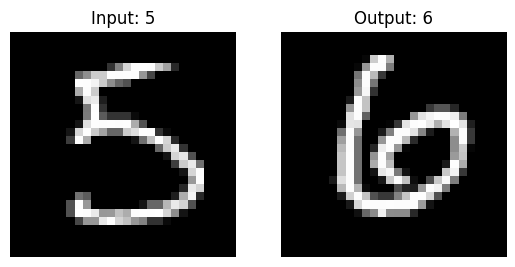

Text Input: What number is this?
Response: what can i help
Top expert used: 5
Gating probs: [0.178 0.154 0.168 0.151 0.171 0.179]
Image input digit: 4, incremented output digit: 5


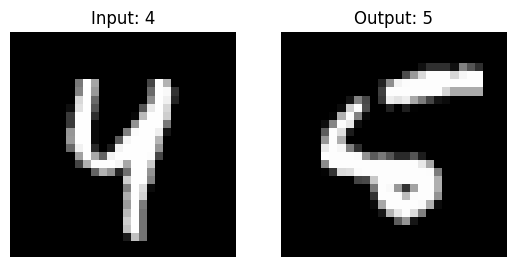

In [34]:
# ---------------------------------------------
# Demo code to test multimodal system
# ---------------------------------------------

# Text only
multimodal_handler(input_text="hello, how are you?")

# Image only (from MNIST test)
multimodal_handler(input_image=x_test_mnist[15])

# Both
multimodal_handler(input_text="What number is this?", input_image=x_test_mnist[42])

In [ ]:
greeting_examples = [
    "hello",
    "hi there",
    "good morning",
    "hey, how are you?",
    "what's up?"
]

goodbye_examples = [
    "goodbye",
    "see you later",
    "bye for now",
    "talk to you soon",
    "have a great day"
]

order_food_examples = [
    "I want to order a pizza",
    "can I get a burger please?",
    "what sides do you have?",
    "I'd like a vegetarian pasta",
    "do you have gluten free options?"
]

weather_examples = [
    "what's the weather today?",
    "will it rain tomorrow?",
    "is it sunny outside?",
    "what's the forecast for this week?",
    "do I need an umbrella today?"
]

miscellaneous_examples = [
    "what's your name?",
    "can you tell me a joke?",
    "how do I say goodbye politely?",
    "are you open on weekends?",
    "what time do you close?"
]

inference_prompts = 
for input_text in inference_prompts:
    multimodal_handler(input_text)

    # print("Input:", input_text)
    # print("Generated response:", response)
    # print("Top expert used:", expert_used)
    # print("Gating probabilities:", np.round(gating_distribution, 3))
    print("---------------------------------")

Text Input: hello there
Response: how can i help
Top expert used: 0
Gating probs: [0.189 0.14  0.168 0.175 0.173 0.154]
---------------------------------
Text Input: I want to order pizza
Response: what toppings do you want
Top expert used: 2
Gating probs: [0.181 0.144 0.194 0.155 0.162 0.165]
---------------------------------
Text Input: goodbye
Response: have a nice day
Top expert used: 0
Gating probs: [0.181 0.153 0.154 0.173 0.172 0.167]
---------------------------------
Text Input: can you help me order food
Response: course, what would like to cancel
Top expert used: 0
Gating probs: [0.179 0.143 0.174 0.173 0.156 0.174]
---------------------------------
Text Input: hi, what's going on?
Response: are your assistant, 9 to help
Top expert used: 0
Gating probs: [0.183 0.151 0.17  0.16  0.17  0.165]
---------------------------------
Text Input: will it rain tomorrow?
Response: course, assist you anytime
Top expert used: 5
Gating probs: [0.17  0.139 0.164 0.181 0.159 0.187]
-----------

# Old Code

In [ ]:
# Sample data (input, response)
train_data = [
    ("hello there", "hi, how can I help"),
    ("hi", "hello, what can I do"),
    ("goodbye", "goodbye, have a nice day"),
    ("see you later", "see you soon, goodbye"),
    ("I want to order pizza", "sure, what toppings do you want"),
    ("can I get a burger", "what size burger would you like"),
    ("what is the weather", "the weather today is sunny"),
    ("is it raining", "no rain expected today"),
    ("hey, I want some pasta", "what kind of pasta would you prefer"),
    ("do you have vegetarian options?", "yes, we have several vegetarian dishes"),
    ("good morning", "good morning, how may I assist you?"),
    ("bye", "take care, see you later"),
    ("will it be hot today?", "expect warm temperatures all day"),
    ("can I order a salad?", "what dressing would you like on your salad?"),
    ("thanks, goodbye", "you're welcome, goodbye!"),
    ("tell me the forecast", "the forecast shows clear skies"),
    ("what's your name?", "i am your assistant, here to help"),
    ("can I have a coffee?", "sure, would you like it black or with milk?"),
    ("thank you for the help", "happy to assist you anytime"),
    ("are you open today?", "yes, we are open from 9 am to 9 pm"),
    ("could you help me with my order", "of course, what would you like to order"),
    ("are there any gluten free options", "yes, we have several gluten free dishes available"),
    ("what are today's specials", "today's special is grilled salmon with vegetables"),
    ("how late are you open", "we are open until 10 pm tonight"),
    ("can you recommend a dessert", "our chocolate lava cake is very popular"),
    ("I need to change my order", "sure, what changes would you like to make"),
    ("do you deliver", "yes, we deliver within a 5 mile radius"),
    ("what payment methods do you accept", "we accept cash, credit cards, and mobile payments"),
    ("is there a parking facility", "yes, free parking is available behind the restaurant"),
    ("thank you very much", "you're welcome, happy to help"),
    ("I have a food allergy", "please let us know your allergy, and we will accommodate"),
    ("can I book a table", "yes, for how many people and what time"),
    ("what's your restaurant address", "we are located at 123 Main Street"),
    ("do you have vegan meals", "yes, we offer delicious vegan options"),
    ("can I get nutritional information", "nutritional info is available on our website"),
    ("how long is the wait time", "usually about 15 minutes during peak hours"),
    ("do you have a kids menu", "yes, we have a special menu for children"),
    ("can I cancel my order", "please provide your order number to cancel"),
    ("what are your opening hours", "we are open from 9 am to 10 pm daily"),
    ("is takeout available", "yes, you can order takeout anytime during opening hours"),        
]

# Build vocabulary
all_texts = [t[0] + " " + t[1] for t in train_data]
all_words = set(word for sentence in all_texts for word in sentence.lower().split())
word2idx = {w: i + 1 for i, w in enumerate(sorted(all_words))}
idx2word = np.array(['<pad>'] + sorted(all_words))
vocab_size = len(idx2word)

max_input_len = 6
max_resp_len = 8

def encode_sentence(sent, max_len):
    words = sent.lower().split()
    seq = [word2idx.get(w, 0) for w in words]
    seq = seq[:max_len] + [0] * (max_len - len(seq))
    return seq

X_input = np.array([encode_sentence(t[0], max_input_len) for t in train_data])
X_resp_in = np.array([encode_sentence(t[1], max_resp_len) for t in train_data])
X_resp_out = np.array([encode_sentence(t[1], max_resp_len)[1:] + [0] for t in train_data]) # shifted

class Expert(Model):
    def __init__(self, d_model):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization()
        self.dense1 = Dense(64, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense2 = Dense(d_model)
    def call(self, x):
        x = self.norm(x)
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

class GatingNetwork(Model):
    def __init__(self, d_model, num_experts):
        super().__init__()
        self.dense = Dense(num_experts)
        self.softmax = Softmax(axis=-1)
    def call(self, x):
        logits = self.dense(x)
        return self.softmax(logits)

class MoEResponseGenerator(Model):
    def __init__(self, vocab_size, d_model, num_experts, max_resp_len, lstm_units=128):
        super().__init__()
        self.embedding = Embedding(vocab_size, d_model, mask_zero=True)
        self.global_pool = GlobalAveragePooling1D()
        self.num_experts = num_experts
        self.experts = [Expert(d_model) for _ in range(num_experts)]
        self.gating_net = GatingNetwork(d_model, num_experts)
        self.lstm_units = lstm_units
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.to_h = Dense(lstm_units)
        self.to_c = Dense(lstm_units)
        self.output_layer = Dense(vocab_size)
        self.max_resp_len = max_resp_len

    def call(self, inputs, training=False):
        input_seq, resp_in_seq = inputs
        enc_emb = self.embedding(input_seq)
        pooled = self.global_pool(enc_emb)

        gating_probs = self.gating_net(pooled)
        expert_outs = tf.stack([expert(pooled) for expert in self.experts], axis=1)
        gated_rep = tf.reduce_sum(tf.expand_dims(gating_probs, 2) * expert_outs, axis=1)

        h_state = self.to_h(gated_rep)
        c_state = self.to_c(gated_rep)

        resp_emb = self.embedding(resp_in_seq)
        lstm_out, _, _ = self.lstm(resp_emb, initial_state=[h_state, c_state])

        logits = self.output_layer(lstm_out)
        return logits, gating_probs

# Hyperparams and dataset
d_model = 32
num_experts = 4
batch_size = 2
epochs = 250

dataset = tf.data.Dataset.from_tensor_slices(((X_input, X_resp_in), X_resp_out)).shuffle(20).batch(batch_size)

model = MoEResponseGenerator(vocab_size, d_model, num_experts, max_resp_len)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits, _ = model(inputs, training=True)
        loss = loss_fn(labels, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

for epoch in range(epochs):
    total_loss = 0
    for in_batch, out_batch in dataset:
        loss = train_step(in_batch, out_batch)
        total_loss += loss.numpy()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss/len(dataset):.4f}")

In [ ]:
def sample_from_logits(logits, temperature=1.0, top_k=5):
    logits = logits / temperature
    if top_k > 0:
        values, _ = tf.math.top_k(logits, k=top_k)
        min_values = values[:, -1, None]
        logits = tf.where(
            logits < min_values,
            tf.fill(tf.shape(logits), float('-inf')),
            logits,
        )
    probabilities = tf.nn.softmax(logits)
    next_token = tf.random.categorical(tf.math.log(probabilities), num_samples=1)
    return tf.squeeze(next_token, axis=-1).numpy()

def generate_response(model, input_text, max_len=30, temperature=1.0, top_k=5):
    input_seq = np.array([encode_sentence(input_text, max_input_len)])
    response_seq = np.zeros((1, max_resp_len), dtype=np.int32)
    generated_tokens = []
    gating_probs = None

    for i in range(max_len):
        logits, gating_probs = model((input_seq, response_seq), training=False)
        logits_step = logits[:, i % max_resp_len, :]
        
        next_token = sample_from_logits(logits_step, temperature=temperature, top_k=top_k)[0]

        if next_token == 0:  # end on padding token
            break
        
        generated_tokens.append(idx2word[next_token])
        if i + 1 < max_resp_len:
            response_seq[0, i] = next_token
        else:
            response_seq = np.roll(response_seq, -1, axis=1)
            response_seq[0, -1] = next_token

    top_expert = np.argmax(gating_probs[0].numpy()) if gating_probs is not None else -1
    return " ".join(generated_tokens), top_expert, gating_probs[0].numpy()


# Demo
inference_prompts = [
    "hello there",
    "I want to order pizza",
    "goodbye",
    "can you help me order food",
    "hi, what's going on?",
    "will it rain tomorrow?",
    "how do I say goodbye politely?",
    "what toppings do you have?",
    "is today sunny or cloudy?",
    "see you soon"
]
for input_text in inference_prompts:
    response, expert_used, gating_distribution = generate_response(model, input_text, max_len=500)

    print("Input:", input_text)
    print("Generated response:", response)
    print("Top expert used:", expert_used)
    print("Gating probabilities:", np.round(gating_distribution, 3))
    print("---------------------------------")

In [ ]:
from PIL import Image
import numpy as np

def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)
    mean_colors = image_array.mean(axis=(0, 1))
    color_names = ['red', 'green', 'blue']
    dominant_color = color_names[np.argmax(mean_colors)]
    return f"Dominant color is {dominant_color}."

def multimodal_response(model, input_text=None, image_path=None):
    result = ""
    if input_text:
        # Use your generate_response logic for text
        response, exp_used, gating_distribution = generate_response(model, input_text, max_len=30)
        result += f"Text response: {response}\nTop expert used: {exp_used}\n"
    if image_path:
        # Classify the image
        image_result = classify_image(image_path)
        result += f"Image analysis: {image_result}\n"
    return result

# Example usage:
print(multimodal_response(model, input_text="what toppings do you have?", image_path="sample_image.jpg"))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Softmax, LSTM, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# ----------- MNIST DIGIT CLASSIFIER -----------

class DigitClassifier(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3,3), activation='relu')
        self.pool1 = MaxPooling2D((2,2))
        self.conv2 = Conv2D(64, (3,3), activation='relu')
        self.pool2 = MaxPooling2D((2,2))
        self.flatten = Flatten()
        self.dense = Dense(64, activation='relu')
        self.out = Dense(10)  # digits 0-9 logits

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.out(x)

def prepare_mnist_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)

# Train or load a pretrained digit classifier
digit_classifier = DigitClassifier()
(x_train, y_train), (x_test, y_test) = prepare_mnist_data()
digit_classifier.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print("Training digit classifier (this may take a bit)...")
digit_classifier.fit(x_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

# ----------- YOUR MOE TEXT GENERATION MODEL (copy your existing) -----------

# (Paste your current MoEResponseGenerator, Expert, GatingNetwork, encode_sentence, sample_from_logits, etc. here)
# For brevity, let's assume it's loaded as `moe_model`

# For this example, just a placeholder generate_response:
def generate_response(model, input_text, max_len=30, temperature=1.0, top_k=5):
    # Use your real model's generation logic here
    return f"Simulated response to: {input_text}", 1, np.array([0.1, 0.7, 0.1, 0.1])

# ----------- MNIST INCREMENT LOGIC -----------

def get_incremented_digit_image(input_image, x_dataset, y_dataset):
    # Normalize pixel values and ensure float32
    img = input_image.astype('float32')
    if img.max() > 1.0:
        img /= 255.0

    # Add channel dimension if missing
    if len(img.shape) == 2:   # grayscale image shape (28,28)
        img = np.expand_dims(img, axis=-1)  # become (28,28,1)

    # Add batch dimension for model input
    img = np.expand_dims(img, axis=0)  # become (1,28,28,1)

    logits = digit_classifier(img)
    pred_digit = tf.argmax(logits, axis=1).numpy()[0]

    inc_digit = 0 if pred_digit == 9 else pred_digit + 1
    idx = np.where(y_dataset == inc_digit)[0][0]
    inc_image = x_dataset[idx][:, :, 0]  # remove channel for display

    return pred_digit, inc_digit, inc_image


# ----------- MULTIMODAL HANDLER -----------

def multimodal_handler(input_text=None, input_image=None):
    if input_text:
        response, expert, gating = generate_response(None, input_text)
        print(f"Text Input: {input_text}")
        print(f"Response: {response}")
        print(f"Top expert used: {expert}")
        print(f"Gating probabilities: {gating}")
    if input_image is not None:
        pred_digit, inc_digit, inc_image = get_incremented_digit_image(input_image, x_test, np.argmax(y_test, axis=1))
        print(f"Input Digit: {pred_digit}, Incremented Digit: {inc_digit}")
        plt.subplot(1,2,1)
        plt.imshow(input_image, cmap='gray')
        plt.title(f"Input: {pred_digit}")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(inc_image, cmap='gray')
        plt.title(f"Output: {inc_digit}")
        plt.axis('off')
        plt.show()

# ----------- DEMO -----------

# Text-only
multimodal_handler(input_text="I need help with my order.")

# Image-only
multimodal_handler(input_image=x_test[5])

# Both modalities
multimodal_handler(input_text="What digit is this?", input_image=x_test[7])
